# Linear Regression
with extra varaibles and split data sets

In [89]:
# import libraries
import pandas as pd

import sys
sys.path.append('../0_DataPreparation')
from utils import plot_missing_heatmap

# import linear regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_percentage_error


In [90]:
# read train and validation data frame from ../data/processed

df_train_clean = pd.read_csv("../data/processed/df_train_data_cleaned.csv")
df_validation_clean = pd.read_csv("../data/processed/df_validation_data_cleaned.csv")
df_test_clean = pd.read_csv("../data/processed/df_test_data_cleaned.csv")

# convert Datum column to datetime
df_train_clean['Datum'] = pd.to_datetime(df_train_clean['Datum'])
df_validation_clean['Datum'] = pd.to_datetime(df_validation_clean['Datum'])
df_test_clean['Datum'] = pd.to_datetime(df_test_clean['Datum'])


# add month to train
df_train_clean['month'] = df_train_clean['Datum'].dt.month
# add month to validation
df_validation_clean['month'] = df_validation_clean['Datum'].dt.month
# add month to test
df_test_clean['month']= df_test_clean['Datum'].dt.month

# print shape of the datasets
print(f"Train data shape: {df_train_clean.shape}")
print(f"Validation data shape: {df_validation_clean.shape}")
print(f"Test data shape: {df_test_clean.shape}")

if 'experiment_results_LR' not in globals():
    experiment_results_LR = pd.DataFrame(columns=['R2_Train', 'R2_Validation', 'MAPE_Validation','selected_columns'])

if 'experiment_results_PR' not in globals():
    experiment_results_PR = pd.DataFrame(columns=['R2_Train', 'R2_Validation', 'MAPE_Validation','selected_columns'])


Train data shape: (7487, 18)
Validation data shape: (1841, 18)
Test data shape: (1830, 17)


### Dropping extra variables

In [91]:
# ignore some columns
drop_columns = ['Datum', 'umsatz_rolling7','temperature_2m_mean','sunshine_duration','is_saturday','is_sunday']

# drop columns if present
drop_columns = [col for col in drop_columns if col in df_train_clean.columns]

# drop columns from train and validation datasets
df_train_clean = df_train_clean.drop(columns=drop_columns)
df_validation_clean = df_validation_clean.drop(columns=drop_columns)


### Selected Variables

In [92]:
selected_columns = ['Umsatz_umsatz', 'Warengruppe_umsatz', 'day_of_week', 'Temperatur_weather', 'month', 'KielerWoche_kiwo']
df_train_clean = df_train_clean[selected_columns]
df_validation_clean = df_validation_clean[selected_columns]

### Categorial_cols

In [93]:
categorical_cols = ['Warengruppe_umsatz', 'day_of_week','month','Bewoelkung_weather','school_holiday','KielerWoche_kiwo','public_holiday','next_day_holiday']
# filter to only those present in the data
categorical_cols = [col for col in categorical_cols if col in df_train_clean.columns]

df_train_clean_cat = pd.get_dummies(df_train_clean, columns=categorical_cols, drop_first=False) 
df_validation_clean_cat = pd.get_dummies(df_validation_clean, columns=categorical_cols, drop_first=False)

# ensure train and validation have the same columns (in case of missing categories in validation)
df_validation_clean_cat = df_validation_clean_cat.reindex(columns=df_train_clean_cat.columns, fill_value=0)

In [94]:
correlations_with_target = df_train_clean_cat.corr()['Umsatz_umsatz'].sort_values(ascending=False)
print(correlations_with_target)

Umsatz_umsatz             1.000000
Warengruppe_umsatz_2.0    0.670450
Warengruppe_umsatz_5.0    0.238443
Temperatur_weather        0.216569
month_8                   0.173527
month_7                   0.134890
day_of_week_6             0.109829
day_of_week_5             0.097841
KielerWoche_kiwo_1.0      0.053631
month_6                   0.034507
month_9                   0.012460
month_10                  0.006555
month_5                   0.006138
month_4                  -0.012115
day_of_week_4            -0.027166
day_of_week_3            -0.036607
month_2                  -0.036918
day_of_week_0            -0.037176
day_of_week_2            -0.050720
KielerWoche_kiwo_0.0     -0.053631
month_3                  -0.054998
day_of_week_1            -0.055598
month_12                 -0.078531
month_1                  -0.078603
month_11                 -0.109976
Warengruppe_umsatz_3.0   -0.150665
Warengruppe_umsatz_6.0   -0.173541
Warengruppe_umsatz_1.0   -0.293144
Warengruppe_umsatz_4

In [95]:

# prepare features and target
# assuming 'Umsatz' is the target column
target = 'Umsatz_umsatz'
X_train = df_train_clean_cat.drop(columns=[target])
y_train = df_train_clean_cat[target]
X_validation = df_validation_clean_cat.drop(columns=[target])
y_validation = df_validation_clean_cat[target]

# fit the model
model = LinearRegression()
model.fit(X_train, y_train)


# print learned equation
print("Learned equation:")
equation = f"y = {model.intercept_:.4f}"
for feature, coef in zip(X_train.columns, model.coef_):
    equation += f" + ({coef:.4f}) * {feature}"
print(equation)

# calculate R2 on train and validation
y_train_pred = model.predict(X_train)
y_validation_pred = model.predict(X_validation)

r2_train = r2_score(y_train, y_train_pred)
r2_validation = r2_score(y_validation, y_validation_pred)

print(f"R2 on train: {r2_train}")
print(f"R2 on validation: {r2_validation}")

# calculate MAPE on validation
mape_validation = mean_absolute_percentage_error(y_validation, y_validation_pred)
print(f"MAPE on validation: {mape_validation}")

# concat results in experiment_results_LR
experiment_results_LR = pd.concat([experiment_results_LR, pd.DataFrame({'R2_Train': [r2_train], 'R2_Validation': [r2_validation], 'MAPE_Validation': [mape_validation],'selected_columns':[selected_columns]})], ignore_index=True)
display(experiment_results_LR.tail(5))

Learned equation:
y = 201.2993 + (0.6158) * Temperatur_weather + (-72.2450) * Warengruppe_umsatz_1.0 + (216.9189) * Warengruppe_umsatz_2.0 + (-29.4888) * Warengruppe_umsatz_3.0 + (-105.2581) * Warengruppe_umsatz_4.0 + (87.2784) * Warengruppe_umsatz_5.0 + (-97.2055) * Warengruppe_umsatz_6.0 + (-12.7742) * day_of_week_0 + (-18.8118) * day_of_week_1 + (-19.2929) * day_of_week_2 + (-12.6254) * day_of_week_3 + (-10.9099) * day_of_week_4 + (33.9429) * day_of_week_5 + (40.4713) * day_of_week_6 + (-33.9099) * month_1 + (-15.8720) * month_2 + (-26.5285) * month_3 + (-8.0535) * month_4 + (-1.3319) * month_5 + (0.9601) * month_6 + (50.8029) * month_7 + (79.2559) * month_8 + (1.1594) * month_9 + (3.5544) * month_10 + (-32.3491) * month_11 + (-17.6879) * month_12 + (-17.3147) * KielerWoche_kiwo_0.0 + (17.3147) * KielerWoche_kiwo_1.0
R2 on train: 0.7364745931117096
R2 on validation: 0.7192478376261963
MAPE on validation: 0.318682163040765


,R2_Train,R2_Validation,MAPE_Validation,selected_columns
2,0.747670,0.721122,0.330728,"[Umsatz_umsatz, Warengruppe_umsatz, day_of_wee..."
3,0.736475,0.719248,0.318682,"[Umsatz_umsatz, Warengruppe_umsatz, day_of_wee..."
4,0.747670,0.721122,0.330728,"[Umsatz_umsatz, Warengruppe_umsatz, day_of_wee..."
5,0.747537,0.720708,0.331032,"[Umsatz_umsatz, Warengruppe_umsatz, day_of_wee..."
6,0.736475,0.719248,0.318682,"[Umsatz_umsatz, Warengruppe_umsatz, day_of_wee..."


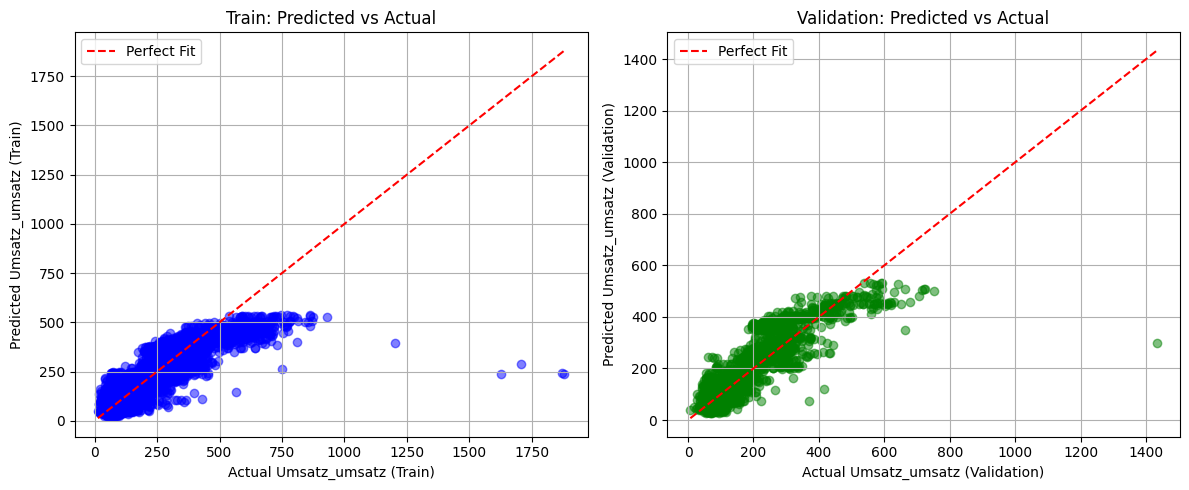

In [96]:
# plot the equation
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# train plot
axes[0].scatter(y_train, y_train_pred, alpha=0.5, color='blue')
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', label='Perfect Fit')
axes[0].set_xlabel('Actual Umsatz_umsatz (Train)')
axes[0].set_ylabel('Predicted Umsatz_umsatz (Train)')
axes[0].set_title('Train: Predicted vs Actual')
axes[0].legend()
axes[0].grid(True)

# validation plot
axes[1].scatter(y_validation, y_validation_pred, alpha=0.5, color='green')
axes[1].plot([y_validation.min(), y_validation.max()], [y_validation.min(), y_validation.max()], 'r--', label='Perfect Fit')
axes[1].set_xlabel('Actual Umsatz_umsatz (Validation)')
axes[1].set_ylabel('Predicted Umsatz_umsatz (Validation)')
axes[1].set_title('Validation: Predicted vs Actual')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

## PolynomialFeature
Captures Non-Linearity: If features like temperature or holidays have quadratic effects on sales, polynomial terms (e.g., x²) fit curves.
- Simple Extension: Still uses LinearRegression, but on transformed features.
- Risks: Higher degrees increase complexity/overfitting; monitor validation R².

Learned equation for polynomial regression:
y = 224.5360 + (-0.8733) * Temperatur_weather + (-28.1460) * Warengruppe_umsatz_1.0 + (75.9275) * Warengruppe_umsatz_2.0 + (-14.3442) * Warengruppe_umsatz_3.0 + (-39.5502) * Warengruppe_umsatz_4.0 + (39.8242) * Warengruppe_umsatz_5.0 + (-33.7113) * Warengruppe_umsatz_6.0 + (-5.6190) * day_of_week_0 + (-10.9385) * day_of_week_1 + (-6.8457) * day_of_week_2 + (3.5933) * day_of_week_3 + (-1.2017) * day_of_week_4 + (12.8737) * day_of_week_5 + (8.1377) * day_of_week_6 + (-11.7259) * month_1 + (-6.3407) * month_2 + (-13.7646) * month_3 + (-5.0244) * month_4 + (16.4806) * month_5 + (6.4670) * month_6 + (2.2612) * month_7 + (45.6293) * month_8 + (-0.9015) * month_9 + (-21.4462) * month_10 + (-10.2580) * month_11 + (-1.3770) * month_12 + (-17.0568) * KielerWoche_kiwo_0.0 + (17.0568) * KielerWoche_kiwo_1.0 + (0.0280) * Temperatur_weather^2 + (-0.6500) * Temperatur_weather Warengruppe_umsatz_1.0 + (2.7906) * Temperatur_weather Warengruppe_umsatz_2.0 + (0

,R2_Train,R2_Validation,MAPE_Validation,selected_columns
0,0.871821,0.801346,0.249269,"[Umsatz_umsatz, Warengruppe_umsatz, day_of_wee..."
1,0.870713,0.798893,0.250869,"[Umsatz_umsatz, Warengruppe_umsatz, day_of_wee..."
2,0.835976,0.809304,0.232097,"[Umsatz_umsatz, Warengruppe_umsatz, day_of_wee..."


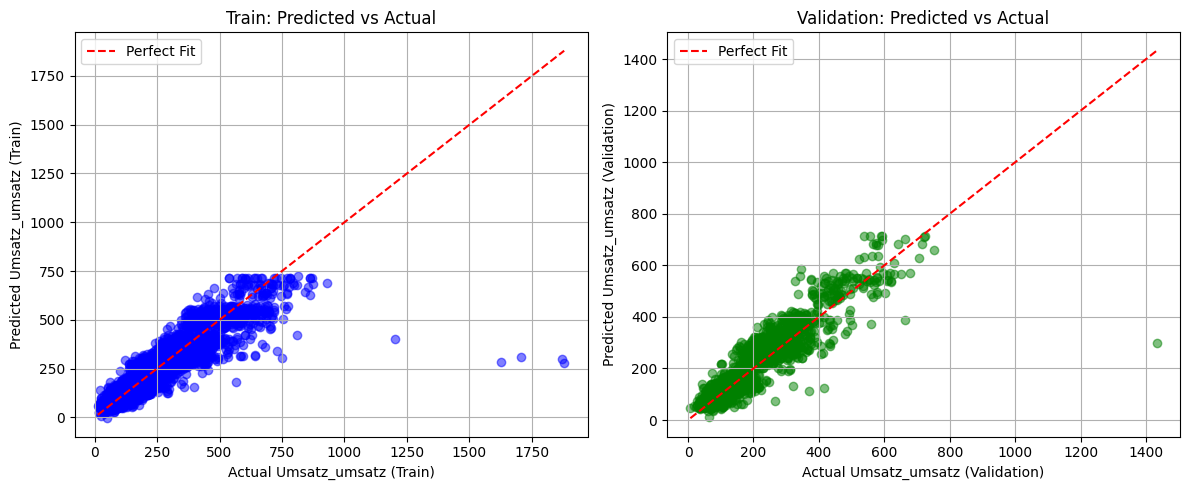

In [97]:
# ...existing code...

from sklearn.preprocessing import PolynomialFeatures

# prepare features and target
target = 'Umsatz_umsatz'
X_train = df_train_clean_cat.drop(columns=[target])
y_train = df_train_clean_cat[target]
X_validation = df_validation_clean_cat.drop(columns=[target])
y_validation = df_validation_clean_cat[target]

# add polynomial features (degree 2 for quadratic)
poly = PolynomialFeatures(degree=2, include_bias=False)

X_train_poly = poly.fit_transform(X_train)
X_validation_poly = poly.transform(X_validation)

# fit polynomial regression (still LinearRegression on transformed features)
model = LinearRegression()
model.fit(X_train_poly, y_train)

print("Learned equation for polynomial regression:")
equation = f"y = {model.intercept_:.4f}"
feature_names = poly.get_feature_names_out(X_train.columns)
for feature, coef in zip(feature_names, model.coef_):
    equation += f" + ({coef:.4f}) * {feature}"
print(equation)

# predict
y_train_pred = model.predict(X_train_poly)
y_validation_pred = model.predict(X_validation_poly)

# evaluate
r2_train = r2_score(y_train, y_train_pred)
r2_validation = r2_score(y_validation, y_validation_pred)
mape_validation = mean_absolute_percentage_error(y_validation, y_validation_pred)

print(f"R2 on train: {r2_train:.4f}")
print(f"R2 on validation: {r2_validation:.4f}")
print(f"MAPE on validation: {mape_validation:.4f}")

# concat results in experiment_results_PR
experiment_results_PR = pd.concat([experiment_results_PR, pd.DataFrame({'R2_Train': [r2_train], 'R2_Validation': [r2_validation], 'MAPE_Validation': [mape_validation],'selected_columns':[selected_columns]})], ignore_index=True)
display(experiment_results_PR.tail(5))

# plot predicted vs actual (same as before)
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].scatter(y_train, y_train_pred, alpha=0.5, color='blue')
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', label='Perfect Fit')
axes[0].set_xlabel('Actual Umsatz_umsatz (Train)')
axes[0].set_ylabel('Predicted Umsatz_umsatz (Train)')
axes[0].set_title('Train: Predicted vs Actual')
axes[0].legend()
axes[0].grid(True)

axes[1].scatter(y_validation, y_validation_pred, alpha=0.5, color='green')
axes[1].plot([y_validation.min(), y_validation.max()], [y_validation.min(), y_validation.max()], 'r--', label='Perfect Fit')
axes[1].set_xlabel('Actual Umsatz_umsatz (Validation)')
axes[1].set_ylabel('Predicted Umsatz_umsatz (Validation)')
axes[1].set_title('Validation: Predicted vs Actual')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# ...existing code...